In [1]:
import pandas as pd
import numpy as np
import os
import math
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_curve
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
%matplotlib inline

In [2]:
train_df = pd.read_csv('../dataset/train_cleaned.csv', sep='|')
val_df = pd.read_csv('../dataset/val_cleaned.csv', sep='|')

In [3]:
labels_1 = ['Age', 'HR', 'Temp', 'Resp', 'SBP', 'MAP', 'DBP']
labels_2 = ['hr_label', 'age_label', 'temp_label', 'resp_label', 'sbp_label', 'map_label', 'dbp_label']
train_df = train_df.drop(columns=labels_2)
val_df = val_df.drop(columns=labels_2)
X_train = train_df.drop(columns=['patient_id', 'SepsisLabel'])
y_train = train_df.SepsisLabel
X_val = val_df.drop(columns=['patient_id', 'SepsisLabel'])
y_val = val_df.SepsisLabel

In [7]:
len(train_df.columns)

18

In [4]:
bbc = BalancedBaggingClassifier(n_estimators=300,
                                 bootstrap=True,
                                 base_estimator=DecisionTreeClassifier(class_weight={0:1.35, 1:1},
                                                                       max_depth=12,
                                                                       splitter='best'))
bbc.fit(X_train, y_train)

y_pred = bbc.predict(X_val)
f1_score(y_val, y_pred)



0.13367427916409488

In [5]:
bbc.score(X_val, y_val)

0.8730335820252597

In [6]:
with open('../BBC.pkl', 'wb') as file:
    pkl.dump(bbc, file)

In [93]:
clf = BalancedRandomForestClassifier(n_estimators=300,
                                     max_depth=8,
                                     bootstrap=True,
                                     class_weight={0:1.15, 1:1})
clf.fit(X_train, y_train)

# get f1 score
y_pred = clf.predict(X_val)
f1_score(y_val, y_pred)

0.10893502197850026

In [94]:
clf.score(X_val, y_val)

0.8236125230456433

In [95]:
with open('../BRFC.pkl', 'wb') as file:
    pkl.dump(clf, file)

In [8]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
scores = cross_val_score(bbc, X_val, y_val, scoring='roc_auc',\
                        cv=cv, n_jobs=-1)
print('ROC AUC: %.3f' % np.mean(scores))

ROC AUC: 0.918


In [11]:
y_pred_proba = bbc.predict_proba(X_val)[::, 1]
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

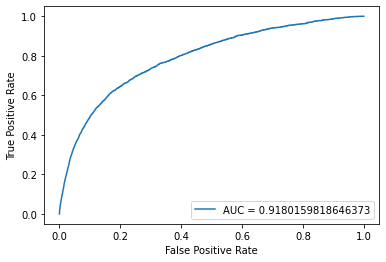

<Figure size 432x288 with 0 Axes>

In [19]:
fig = plt.plot(fpr, tpr, label='AUC = ' + str(np.mean(scores)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
plt.savefig('../img/roc_curve.png')